In [1]:
import sys
import numpy as np
from scipy.stats import multivariate_normal
import signal
import torch
import re
import pandas as pd
from torch.distributions.multivariate_normal import MultivariateNormal
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../SOGA-main/src')
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

torch.set_default_dtype(torch.float64)
from fitness.soga_fitness_trueskills import *
from algorithm.parameters import params
import utils

In [2]:
model_name = 'if_sketch3_30'
program_name = 'if'

In [3]:
from os import getcwd, listdir, path, sep

avg_fitness_5000, text_bf = utils.read_fitness_and_program(model_name)
print('Average fitness of best found program on 5000 data: ', np.nanmean(avg_fitness_5000))

fitness_bf = likelihood_of_program_wrt_data(text_bf, program=program_name, data_size=5000)
path_baseline = path.join(getcwd(), "..", "baselines", program_name + ".soga")
file = open(path_baseline)
text_baseline = ''
for line in file.readlines():
    text_baseline += line + ' '
#text_baseline = 'mu = gm([1, 20, 3]);\nsigma = gm([1,2,1]);\nx = sigma * gm([1,1,1]);\nx = x + mu;'

fitness_bl = likelihood_of_program_wrt_data(text_baseline, program=program_name, data_size=5000)

print('Fitness of best found program: ', fitness_bf)
print('Fitness of baseline: ', fitness_bl)
print(text_bf) 

Average fitness of best found program on 5000 data:  -3.7763710031718674
Fitness of best found program:  -3.7119008143020515
Fitness of baseline:  -3.7113620330832635
a = gm([26.7, 1, 2]) + 0  * gm([2, 6, 25]); 
 if a < 0 { 
   b = 3 * a + gm([1,0.,1.]); 
  } else { 
   b = gm([1,8.,1.]); 
  } end if;
 
 


In [4]:
# Computes SOGA distributions for best found and baseline

soga_bf = preprocess_program(text_bf)
compiledText=compile2SOGA_text(soga_bf)
cfg = produce_cfg_text(compiledText)
output_dist = start_SOGA(cfg)

soga_baseline = preprocess_program(text_baseline)
compiledText_baseline=compile2SOGA_text(soga_baseline)
cfg_baseline = produce_cfg_text(compiledText_baseline)
output_dist_baseline = start_SOGA(cfg_baseline)

In [5]:
# Generates data from original data generating process 

from fitness import data_generating_process as dgp  

data = dgp.generate_dataset(program_name, 5000)
data_var_list, dependencies, weights = dgp.get_vars(program_name)

In [11]:
def get_mixture_pdf(point, var, dist):
    pdf = 0
    #indexes = {element: [index for index, value in enumerate(output_dist.var_list) if value == element] for element in data_var_list}
    for i in range(dist.gm.n_comp()):
        marginal_means = []
        covariance_index = []
        #for element, index_list in indexes.items():
        marginal_means.append(dist.gm.mu[i][dist.var_list.index(var)])
        covariance_index.append(dist.var_list.index(var))

        marginal_covariance_matrix = dist.gm.sigma[i][np.ix_(covariance_index,covariance_index)]
        
        pdf+= dist.gm.pi[i] * multivariate_normal.pdf(point, mean = marginal_means, cov = marginal_covariance_matrix, allow_singular=True)

    return pdf
        

/var/folders/wj/s0d4084s7rz93njmy26_wwnw0000gn/T/ipykernel_52746/2114348674.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', len(data_var_list))


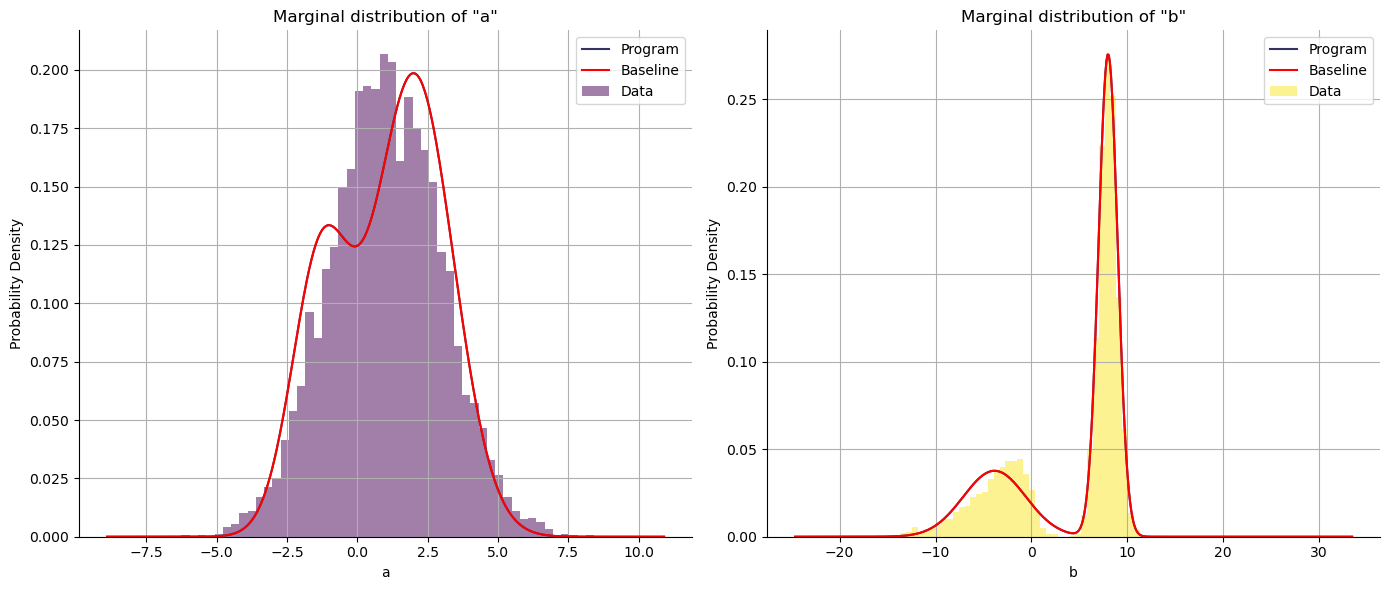

In [ ]:
import matplotlib
#matplotlib.use('TkAgg') 

import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.cm as cm


# Define the range for the uniform distribution
x = np.linspace(-10, 10, 500)
x = torch.tensor(x)

# Assuming data_var_list is defined
#data_var_list = ['a', 'b']  # Example list, replace with your actual list
colormap = cm.get_cmap('viridis', len(data_var_list))
colors = [colormap(i) for i in range(len(data_var_list))]

def plot_marginal_distribution(data, data_var_list, dist, colors=colors, baseline=None):

    # Create a figure with subplots
    fig, axs = plt.subplots(1, len(data_var_list), figsize=(14, 6))

    # If there's only one element in data_var_list, axs will not be an array, so we need to handle that case
    if len(data_var_list) == 1:
        axs = [axs]

    # Loop through each element in data_var_list and create a subplot
    for i, var in enumerate(data_var_list):
        color = colors[i]
        # select the x axis
        mean = np.mean([pair[i] for pair in data])
        std = np.std([pair[i] for pair in data])
        x = np.linspace(mean-5*std, mean+5*std, 500)
        x = torch.tensor(x)
        # plots
        axs[i].plot(x, [get_mixture_pdf([xi], var, dist) for xi in x], label='Synthesized Program', color='#333366')   
        if baseline:
            axs[i].plot(x, [get_mixture_pdf([xi], var, baseline) for xi in x], label='Baseline Program', color='red')  
        axs[i].hist([pair[i] for pair in data], bins=50, density=True, alpha=0.5, color=color, label='Data')
        axs[i].set_title(f'Marginal distribution of "{var}"')
        axs[i].set_xlabel(f"{var}")
        axs[i].set_ylabel("Probability Density")
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['top'].set_visible(False)
        axs[i].grid(True)
        axs[i].legend()

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

plot_marginal_distribution(data, data_var_list, output_dist, baseline=output_dist_baseline)

In [8]:
#utils.create_histogram(data, ['skill1', 'skill2', 'p1wins'])
#data_program = utils.sample_gmm(output_dist, 500)
#take first, second and last column of data
#data_program = data_program[:, [0, 1, 3]]

#utils.create_histogram(data_program, ['skill1', 'skill2', 'p1wins'])



/var/folders/wj/s0d4084s7rz93njmy26_wwnw0000gn/T/ipykernel_52746/2812870630.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = matplotlib.cm.get_cmap('viridis')


FloatingPointError: underflow encountered in exp

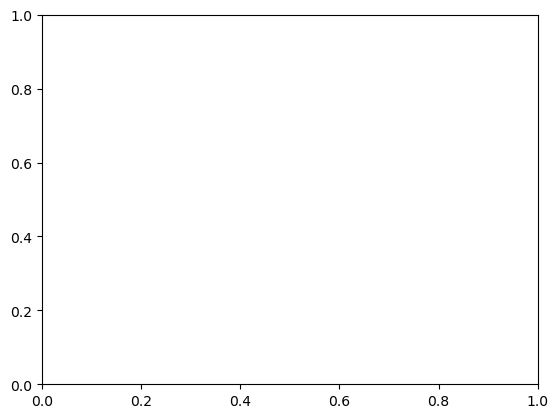

In [9]:
#3D image of the joint distribution
from mpl_toolkits.mplot3d import Axes3D

def get_mixture_pdf(point, data_var_list = data_var_list):
    pdf = 0
    indexes = {element: [index for index, value in enumerate(output_dist.var_list) if value == element] for element in data_var_list}
    for i in range(output_dist.gm.n_comp()):
        marginal_means = []
        covariance_index = []
        for element, index_list in indexes.items():
            marginal_means.append(output_dist.gm.mu[i][index_list][0])
            covariance_index.append(index_list[0])

        marginal_covariance_matrix = output_dist.gm.sigma[i][np.ix_(covariance_index,covariance_index)]
        
        pdf+= + output_dist.gm.pi[i] * multivariate_normal.pdf(point, mean = marginal_means, cov = marginal_covariance_matrix, allow_singular=True)

    return pdf
        
color_map = matplotlib.cm.get_cmap('viridis')
vars_to_plot = ['a', 'b']
idx1 = output_dist.var_list.index(vars_to_plot[0])
mean1 = output_dist.gm.mean()[idx1]
std1= np.sqrt(output_dist.gm.cov()[idx1, idx1])
idx2 = output_dist.var_list.index(vars_to_plot[1])
mean2 = output_dist.gm.mean()[idx2]
std2= np.sqrt(output_dist.gm.cov()[idx2, idx2])
x1 = min(int(mean1-std1), int(np.min([data_point[data_var_list.index(vars_to_plot[0])] for data_point in data])))
x2 = max(int(mean1+std1), int(np.max([data_point[data_var_list.index(vars_to_plot[0])] for data_point in data])) )
y1 = min(int(mean2-std2), int(np.min([data_point[data_var_list.index(vars_to_plot[1])] for data_point in data])) )
y2 = max(int(mean2+std2), int(np.max([data_point[data_var_list.index(vars_to_plot[1])] for data_point in data])) )
x, y = np.mgrid[x1-1:x2+1:.1, y1-1:y2+1:.1]
pos = np.dstack((x, y))
#rv = multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, get_mixture_pdf(pos, vars_to_plot), cmap=color_map)
ax2.scatter([pair[data_var_list.index(vars_to_plot[0])] for pair in data], [pair[data_var_list.index(vars_to_plot[1])] for pair in data], color = 'red', alpha = 0.7, s = 0.8, label = 'Data')
#ax2.set_title("Joint Distribution of the generated program")
ax2.set_xlabel(vars_to_plot[0])
ax2.set_ylabel(vars_to_plot[1])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax2.grid(True)
ax2.legend(loc = 'lower right')